In [ ]:
from time import sleep
import requests
from google.colab import files
import pandas as pd
from bs4 import BeautifulSoup

def soup2list(src, list_, attr=None):
    if attr:
        for val in src:
            list_.append(val[attr])
    else:
        for val in src:
            list_.append(val.get_text())

users = []
userReviewNum = []
ratings = []
locations = []
dates = []
reviews = []

from_page = 1
to_page = 6
company = 'mefx.company'

for i in range(from_page, to_page+1):

   result = requests.get(fr"https://www.trustpilot.com/review/{company}?page={i}")
   soup = BeautifulSoup(result.content)

   # Trust Pilot was setup in a way that's not friendly to scraping, so this hacky method will do.
   soup2list(soup.find_all('span', {'class','typography_heading-xxs__QKBS8 typography_appearance-default__AAY17'}), users)
   soup2list(soup.find_all('div', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua'}), locations)
   soup2list(soup.find_all('span', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l'}), userReviewNum)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), dates)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), ratings, attr='data-service-review-rating')
   soup2list(soup.find_all('div', {'class','styles_reviewContent__0Q2Tg'}), reviews)

   # To avoid throttling
   sleep(1)

review_data = pd.DataFrame(
{
   'Username':users,
   'Total reviews':userReviewNum,
   'location':locations,
   'date':dates,
   'content':reviews,
   'Rating': ratings
})


In [ ]:
review_data

,Username,Total reviews,location,date,content,Rating
0,Darryl Hayton,3 reviews,GB,"Nov 25, 2022",It's going to be an amazing festive…It's going...,5
1,Jude Crown,1 review,CA,"Oct 25, 2022",I have never believed in anything…I have never...,5
2,Stéphane MOTARD,4 reviews,ES,"Aug 6, 2022",Still with the same opinionStill with the same...,1
3,Mahadev Kumar,2 reviews,NP,"Oct 25, 2022",I have never been this lucky in…I have never b...,5
4,Βίκυ Χύτα,3 reviews,GR,"Oct 25, 2022",No regrets since I started investing…No regret...,5
...,...,...,...,...,...,...
111,Asling Elvis,1 review,US,"Jan 29, 2022",Amazing investment company with good…Amazing i...,5
112,Elfrem Neftalem,1 review,GB,"Jun 4, 2021",Amazing passive income projectDate of experien...,5
113,Nabinur Islam,1 review,BD,"Jun 2, 2021",Best Investment platformDate of experience: Ju...,5
114,Byron Clark,1 review,US,"Jun 1, 2021","Awesome platform!Date of experience: June 01, ...",5


In [ ]:
# Convert the DataFrame to a CSV file and download it
review_data.to_csv('reviews.csv', index=False)
files.download('reviews.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Main
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
data_raw = pd.read_csv('reviews.csv')
data_raw.head()

,Username,Total reviews,location,date,content,Rating
0,Darryl Hayton,3 reviews,GB,"Nov 25, 2022",It's going to be an amazing festive…It's going...,5
1,Jude Crown,1 review,CA,"Oct 25, 2022",I have never believed in anything…I have never...,5
2,Stéphane MOTARD,4 reviews,ES,"Aug 6, 2022",Still with the same opinionStill with the same...,1
3,Mahadev Kumar,2 reviews,NP,"Oct 25, 2022",I have never been this lucky in…I have never b...,5
4,Βίκυ Χύτα,3 reviews,GR,"Oct 25, 2022",No regrets since I started investing…No regret...,5


In [ ]:
data = data_raw[['content', 'Rating']]
data.head()

,content,Rating
0,It's going to be an amazing festive…It's going...,5
1,I have never believed in anything…I have never...,5
2,Still with the same opinionStill with the same...,1
3,I have never been this lucky in…I have never b...,5
4,No regrets since I started investing…No regret...,5


<ipython-input-8-ee0e59540a4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment'] = data['Rating'].apply(categorize_review)


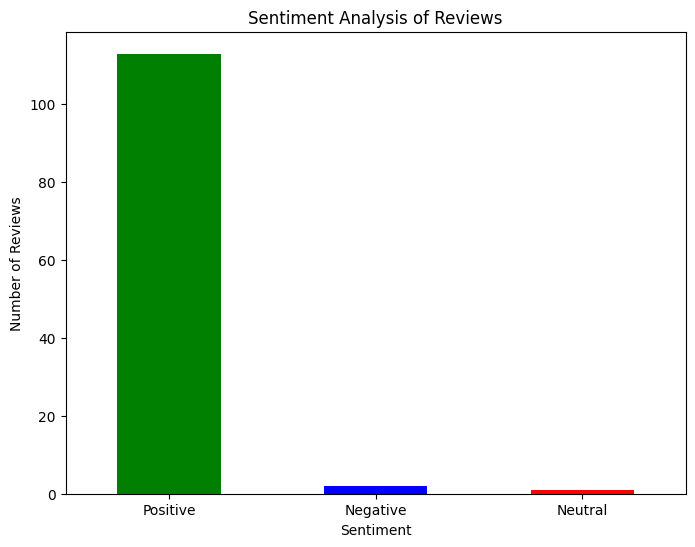

In [ ]:


# Define function to categorize reviews based on ratings
def categorize_review(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to create a new column 'Sentiment'
data['Sentiment'] = data['Rating'].apply(categorize_review)

# Count the number of reviews for each sentiment
sentiment_counts = data['Sentiment'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Analysis of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download required NLTK data files (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()
def preprocess_text(content):
    # Convert to lowercase
    content = content.lower()
    # Remove special characters and digits
    content = re.sub(r'[^a-zA-Z\s]', '', content)
    # Remove punctuation
    content = content.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    words = word_tokenize(content)
    # Remove stopwords and perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    # Join words back into a single string
    return ' '.join(words)



# Apply preprocessing to the 'content' column
data['processed_content'] = data['content'].apply(preprocess_text)

# Display the updated DataFrame with the new 'processed_content' column
print(data.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                             content  Rating Sentiment  \
0  It's going to be an amazing festive…It's going...       5  Positive   
1  I have never believed in anything…I have never...       5  Positive   
2  Still with the same opinionStill with the same...       1  Negative   
3  I have never been this lucky in…I have never b...       5  Positive   
4  No regrets since I started investing…No regret...       5  Positive   

                                   processed_content  
0  going amazing festiveits going amazing festive...  
1  never believed anythingi never believed anythi...  
2  still opinionstill opinion still without respo...  
3  never lucky ini never lucky cryptocurrency tra...  
4  regret since started investingno regret since ...  


<ipython-input-10-583e4d386470>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_content'] = data['content'].apply(preprocess_text)


In [ ]:
data.head()

,content,Rating,Sentiment,processed_content
0,It's going to be an amazing festive…It's going...,5,Positive,going amazing festiveits going amazing festive...
1,I have never believed in anything…I have never...,5,Positive,never believed anythingi never believed anythi...
2,Still with the same opinionStill with the same...,1,Negative,still opinionstill opinion still without respo...
3,I have never been this lucky in…I have never b...,5,Positive,never lucky ini never lucky cryptocurrency tra...
4,No regrets since I started investing…No regret...,5,Positive,regret since started investingno regret since ...


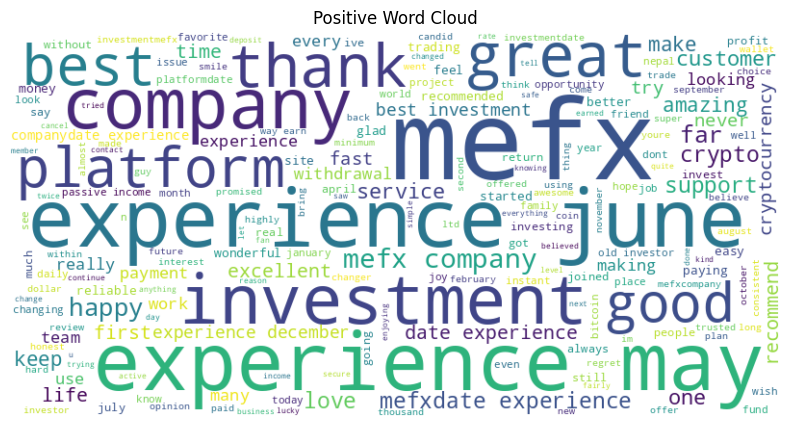

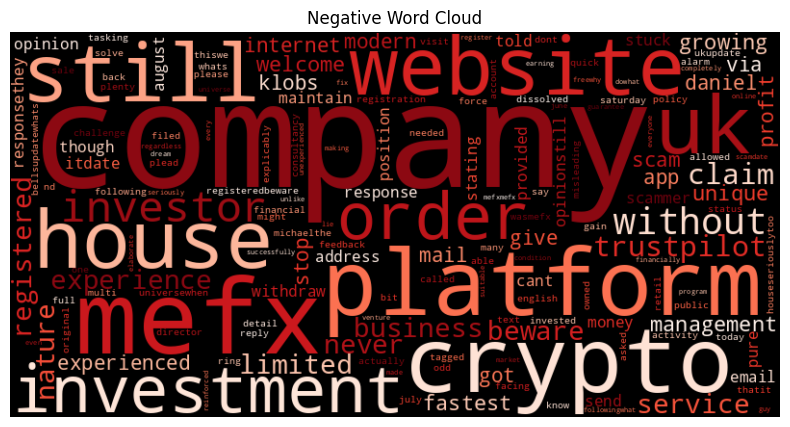

In [ ]:
from wordcloud import WordCloud

# Separate the processed text into positive and negative
positive_reviews = ' '.join(data[data['Sentiment'] == 'Positive']['processed_content']) # Changed 'positive' to 'Positive'
negative_reviews = ' '.join(data[data['Sentiment'] == 'Negative']['processed_content']) # Changed 'negative' to 'Negative'

# Create word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)

# Plot positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Word Cloud')
plt.show()

# Plot negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Word Cloud')
plt.show()